# Chess Deep Learning Agent: EDA and Preprocessing

This notebook covers:
1. Loading PGN data from Lichess
2. Extracting positions with metadata
3. Exploratory data analysis
4. Phase stratification and dataset preparation

## Setup

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import chess

from data.pgn_to_positions import (
    extract_positions_from_pgn,
    save_positions_to_csv,
    load_positions_from_csv,
    clean_positions,
    get_eda_statistics,
)
from data.sampling import stratify_by_phase, train_val_test_split
from utils.plotting import (
    plot_phase_distribution,
    plot_piece_count_distribution,
    plot_outcome_distribution,
)
from utils.seeds import set_seed

set_seed(42)

# Create output directories
DATA_DIR = Path('../artifacts/data')
DATA_DIR.mkdir(parents=True, exist_ok=True)

FIGURES_DIR = Path('../reports/figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

## 1. Data Source

**Lichess Open Database**: https://database.lichess.org/

Download a PGN file (e.g., `lichess_db_standard_rated_2024-01.pgn.zst`)

**Important**: Due to size, DO NOT commit PGN files to git. Extract them locally.

For this demo, we'll use a small sample. In practice:
1. Download monthly PGN from Lichess
2. Extract with: `zstd -d lichess_db_standard_rated_2024-01.pgn.zst`
3. Place in a `data/raw/` directory (add to .gitignore)

In [2]:
# TODO: Update this path to your local PGN file
# To this:
PGN_PATH = Path('../data/raw/Lichess Elite Database/lichess_elite_2019-12.pgn')
MAX_GAMES = 10000  # Start with 10k for testing
MIN_ELO = 2200     # Elite players
SKIP_OPENING_MOVES = 3  # Skip first 3 moves (book moves)

## 2. Extract Positions from PGN

In [3]:
# Extract positions (this may take a few minutes)
if PGN_PATH.exists():
    df_positions = extract_positions_from_pgn(
        PGN_PATH,
        max_games=MAX_GAMES,
        min_elo=MIN_ELO,
        skip_first_n_moves=SKIP_OPENING_MOVES,
    )

    # Save to compressed CSV
    save_positions_to_csv(df_positions, DATA_DIR / 'positions_raw.csv.gz')
else:
    print(f"PGN file not found at {PGN_PATH}")
    print("Creating synthetic data for demo...")

    # Create synthetic dataset for demo
    df_positions = pd.DataFrame({
        'fen': ['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1'] * 1000,
        'move': ['e7e5'] * 1000,
        'outcome': np.random.choice([0.0, 0.5, 1.0], 1000),
        'phase': np.random.choice(['opening', 'middlegame', 'endgame'], 1000, p=[0.3, 0.5, 0.2]),
        'move_number': np.random.randint(4, 80, 1000),
    })

Processing games: 10000 games [01:34, 106.07 games/s]



Extracted 786,494 positions from 10,000 games
Saved 786,494 positions to ../artifacts/data/positions_raw.csv.gz


In [4]:
# Preview data
print(f"Total positions: {len(df_positions):,}")
df_positions.head()

Total positions: 786,494


,fen,move,outcome,phase,move_number
0,rnbqkbnr/pp1ppppp/8/2p5/2P5/6P1/PP1PPP1P/RNBQK...,b8c6,1.0,opening,4
1,r1bqkbnr/pp1ppppp/2n5/2p5/2P5/6P1/PP1PPP1P/RNB...,f1g2,0.0,opening,5
2,r1bqkbnr/pp1ppppp/2n5/2p5/2P5/6P1/PP1PPPBP/RNB...,g8f6,1.0,opening,6
3,r1bqkb1r/pp1ppppp/2n2n2/2p5/2P5/6P1/PP1PPPBP/R...,b1c3,0.0,opening,7
4,r1bqkb1r/pp1ppppp/2n2n2/2p5/2P5/2N3P1/PP1PPPBP...,d7d6,1.0,opening,8


## 3. Exploratory Data Analysis

In [5]:
# Get statistics
stats = get_eda_statistics(df_positions)
print("Dataset Statistics:")
print(f"  Total positions: {stats['total_positions']:,}")
print(f"\n  Phase distribution:")
for phase, count in stats['phase_distribution'].items():
    pct = count / stats['total_positions'] * 100
    print(f"    {phase:12s}: {count:8,} ({pct:5.1f}%)")
print(f"\n  Outcome distribution:")
for outcome, count in stats['outcome_distribution'].items():
    pct = count / stats['total_positions'] * 100
    print(f"    {outcome:5.1f}: {count:8,} ({pct:5.1f}%)")
print(f"\n  Move number stats:")
for key, value in stats['move_number_stats'].items():
    print(f"    {key:10s}: {value:.1f}")

Dataset Statistics:
  Total positions: 786,494

  Phase distribution:
    opening     :  354,002 ( 45.0%)
    middlegame  :  311,078 ( 39.6%)
    endgame     :  121,414 ( 15.4%)

  Outcome distribution:
      1.0:  355,141 ( 45.2%)
      0.0:  351,107 ( 44.6%)
      0.5:   80,246 ( 10.2%)

  Move number stats:
    mean      : 49.8
    median    : 44.0
    min       : 4.0
    max       : 287.0


Saved phase distribution plot to ../reports/figures/phase_distribution.png


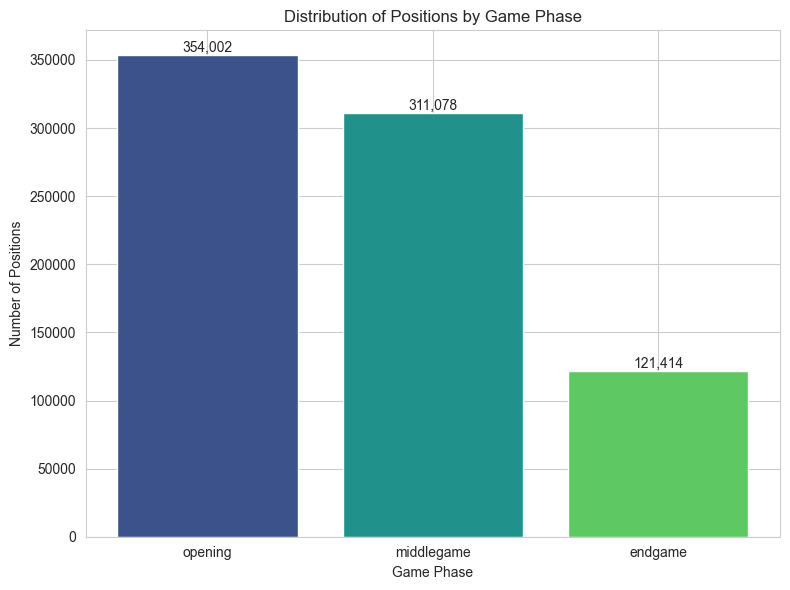

In [6]:
# Plot phase distribution
phase_counts = df_positions['phase'].value_counts().to_dict()
plot_phase_distribution(phase_counts, save_path=FIGURES_DIR / 'phase_distribution.png')

Saved outcome distribution to ../reports/figures/outcome_distribution.png


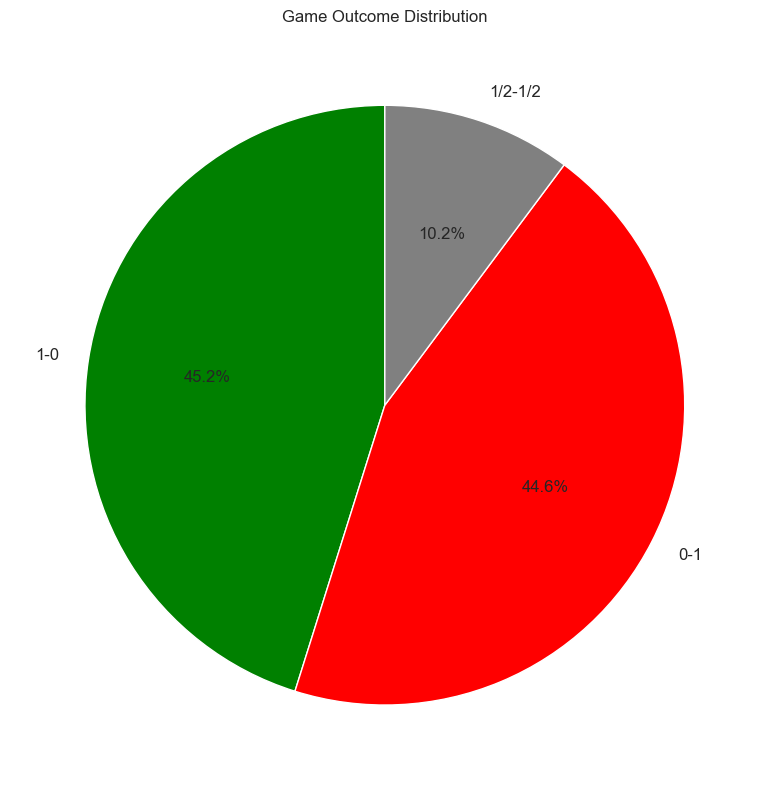

In [7]:
# Plot outcome distribution
outcome_labels = {0.0: '0-1', 0.5: '1/2-1/2', 1.0: '1-0'}
outcome_counts = {outcome_labels[k]: v for k, v in df_positions['outcome'].value_counts().to_dict().items()}
plot_outcome_distribution(outcome_counts, save_path=FIGURES_DIR / 'outcome_distribution.png')

Saved piece count distribution to ../reports/figures/piece_count_distribution.png


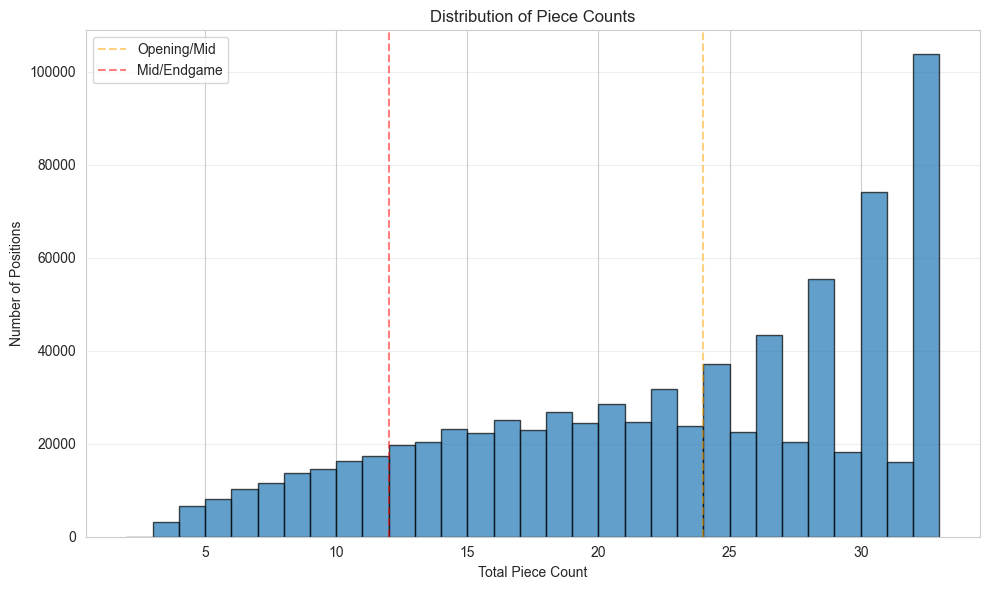

In [8]:
# Analyze piece counts per position
def count_pieces_in_fen(fen):
    board = chess.Board(fen)
    return len(board.piece_map())

piece_counts = df_positions['fen'].apply(count_pieces_in_fen)
plot_piece_count_distribution(piece_counts.tolist(), save_path=FIGURES_DIR / 'piece_count_distribution.png')

## 4. Data Cleaning

In [9]:
# Clean dataset
df_clean = clean_positions(
    df_positions,
    remove_duplicates=True,
    balance_outcomes=False,  # Set True to balance outcomes
)

print(f"\nCleaned dataset: {len(df_clean):,} positions")

Removed 73,096 duplicate positions
Final dataset: 713,398 positions

Cleaned dataset: 713,398 positions


## 5. Phase Stratification and Train/Val/Test Split

In [10]:
# Stratify by phase to target size (e.g., 100k positions)
TARGET_SIZE = min(100_000, len(df_clean))  # Adjust based on available data

df_stratified = stratify_by_phase(
    df_clean,
    target_size=TARGET_SIZE,
    phase_distribution={
        'opening': 0.25,
        'middlegame': 0.50,
        'endgame': 0.25,
    },
)


Stratified sampling summary:
  Target size: 100,000
  Actual size: 100,000
  Phase distribution:
    opening     : 25,000 ( 25.0%)
    middlegame  : 50,000 ( 50.0%)
    endgame     : 25,000 ( 25.0%)


In [11]:
# Train/val/test split (stratified by phase)
train_df, val_df, test_df = train_val_test_split(
    df_stratified,
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    stratify_by='phase',
)


Dataset split:
  Train: 70,000 ( 70.0%)
  Val:   15,000 ( 15.0%)
  Test:  15,000 ( 15.0%)


In [12]:
# Save splits
train_df.to_csv(DATA_DIR / 'train.csv.gz', index=False, compression='gzip')
val_df.to_csv(DATA_DIR / 'val.csv.gz', index=False, compression='gzip')
test_df.to_csv(DATA_DIR / 'test.csv.gz', index=False, compression='gzip')

print("\nSaved datasets:")
print(f"  Train: {DATA_DIR / 'train.csv.gz'}")
print(f"  Val:   {DATA_DIR / 'val.csv.gz'}")
print(f"  Test:  {DATA_DIR / 'test.csv.gz'}")


Saved datasets:
  Train: ../artifacts/data/train.csv.gz
  Val:   ../artifacts/data/val.csv.gz
  Test:  ../artifacts/data/test.csv.gz


## 6. Hypotheses for Later Testing

Based on the EDA, we will test:

1. **Policy Effectiveness**: Does policy-based move ordering improve alpha-beta search strength?
2. **Phase Performance**: Does the value network help more in endgames vs. middlegames?
3. **Training Data**: Does phase-stratified training improve balanced performance across game stages?
4. **ACPL Analysis**: How does our agent's ACPL compare to baseline engines (Sunfish, Stockfish)?

These will be evaluated in notebooks 03 and 04.

## Summary

✓ Extracted positions from PGN
✓ Performed EDA and visualization
✓ Cleaned and stratified data
✓ Created train/val/test splits

**Next**: Notebook 02 - Train supervised policy and value networks